In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
from tenet.util import sphMap
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.optimize import curve_fit
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib widget

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)


In [2]:
os.chdir('/u/reric/Scripts/')
! pwd

/vera/u/reric/Scripts


In [3]:
def load_grpdict(infname, sim='TNG50-1'):
    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                if 'xray' in dset_key:
                    continue
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

sim = 'TNG50-1'
infname = 'central_groups_subfind_%s_branches.hdf5'%sim
groups_grp_dict = load_grpdict(infname, sim)
groups_grp_dict_keys = list(groups_grp_dict.keys())
halos_snapnum099_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum099.hdf5'%sim, sim)
halos_snapnum067_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum067.hdf5'%sim, sim)
halos_snapnum050_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum050.hdf5'%sim, sim)
halos_snapnum033_grp_dict = load_grpdict('central_subfind_%s_branches_snapNum033.hdf5'%sim, sim)

sim = 'L680n8192TNG'

infname = 'central_subfind_%s_branches.hdf5'%sim
TNGCluster_grp_dict = load_grpdict(infname, sim)
TNGCluster_grp_dict_keys = list(TNGCluster_grp_dict.keys())

grp_dicts = [groups_grp_dict,
             halos_snapnum099_grp_dict,
             halos_snapnum067_grp_dict,
             halos_snapnum050_grp_dict,
             halos_snapnum033_grp_dict]


In [4]:
CGMColdGasMass_key = 'SubhaloCGMColdGasMass'
fCGMColdGas_key = 'SubhaloCGMColdGasFraction'

bh_mass_key = 'MainBHMass'
bh_particleID_key = 'MainBHParticleID'
BH_CumEgyInjection_RM_key = 'MainBH_CumEgyInjection_RM'
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'

grp_keys = ['SnapNum', 'CosmicTime', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'SubhaloMass',
            'Subhalo_Mstar_Rgal', 'Subhalo_Rgal',
            'SubhaloColdGasMass', 'SubhaloHotGasMass', 'SubhaloGasMass',
            'SubhaloCGMColdGasMass', 'SubhaloCGMColdGasFraction']

Nsats_total_key = 'Nsatellites_total'
Nsats_fiducial_key = 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c'
Nsats_onlymassive_key = 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c'
Nsats_onlySF_key = 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c'
Nsats_keys = [Nsats_total_key,
              Nsats_fiducial_key,
              Nsats_onlymassive_key,
              Nsats_onlySF_key]

quench_snap_flag = -99
bh_rm_firstsnap_flag = -100

def create_taudict(grp_dict, snaps, branches_flag=False):
    """ 
    Given the grp_dict and snaps of interest, rearrange the grp_dict
    into a 2D array of the datasets at the snaps of interest. 
    snaps should be a list of snapNums, where snapNum -99 
    is the flag to use the quenching_snap.
    Returns the tau_dict.
    """
    # input validation
    if not isinstance(snaps, (list, np.ndarray)):
        snaps = [snaps]

    tau_keys = grp_keys.copy()
    if branches_flag:
        tau_keys.extend(Nsats_keys)
                        
    tauresult = {}
    # begin loop over subhalos
    for group_index, group_key in enumerate(grp_dict):
        group = grp_dict[group_key]
        # if just starting, then initialize the dictionary 
        if group_index == 0:
            tauresult['SubfindID'] = np.zeros(len(grp_dict), dtype=int)
            tauresult['HostSubhaloGrNr'] = np.zeros(len(grp_dict), dtype=int)
            for tau_key in tau_keys:
                for snap in snaps:
                    if snap == quench_snap_flag:
                        tauresult_key = tau_key + '_snapNumQuench'
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    elif snap == bh_rm_firstsnap_flag:
                        tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    else:
                        tauresult_key = tau_key + '_snapNum%03d'%snap
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    
        tauresult['SubfindID'][group_index] = group['SubfindID'][0]
        tauresult['HostSubhaloGrNr'][group_index] = group['HostSubhaloGrNr'][0]
        # finish initializing the the result
        # assign the values at z=0, which are always the 0th element in the array
        for tau_key in tau_keys:
            for snap in snaps:
                if snap == quench_snap_flag:
                    tauresult_key = tau_key + '_snapNumQuench'
                    tau_index = group['quenching_snap'] == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                elif snap == bh_rm_firstsnap_flag:
                    tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                    tau_index = group[BH_RM_FirstSnap_key] == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                else:
                    tauresult_key = tau_key + '_snapNum%03d'%snap
                    tau_index = snap == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
            # finish loop over snaps for the grp_key
        # finish grp_keys for the group
    # finish loop over the groups
    return tauresult
    

In [5]:
groups_tau_dict = create_taudict(groups_grp_dict, [99, 67, 50, 33], branches_flag=True)
halos_snapnum099_tau_dict = create_taudict(halos_snapnum099_grp_dict, 99)
halos_snapnum067_tau_dict = create_taudict(halos_snapnum067_grp_dict, 67)
halos_snapnum050_tau_dict = create_taudict(halos_snapnum050_grp_dict, 50)
halos_snapnum033_tau_dict = create_taudict(halos_snapnum033_grp_dict, 33)
TNGCluster_tau_dict = create_taudict(TNGCluster_grp_dict, [99, 67, 50, 33, bh_rm_firstsnap_flag], branches_flag=True)


In [8]:
figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

outdirec = '/u/reric/Figures/ColdPast/'
sim = 'TNG50-1'
savefig = False

In [9]:
snap_tau_dicts = [halos_snapnum099_tau_dict,
                  halos_snapnum067_tau_dict,
                  halos_snapnum050_tau_dict]

snapNums = [99, 67, 50]

result1 = []
result2 = []
percentiles = [16, 50, 84]
binwidth = 0.2 # log[M200c]
for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]

    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum

    y1 = tau_dict[y1_key]
    mask = y1 > 0
    y1 = np.log10(y1[mask])
    x = np.log10(tau_dict[x_key][mask])
    y2 = np.log10(tau_dict[y2_key][mask])

    result1.append(ru.return2dhiststats_dict(x, y1, binwidth, percentiles=percentiles))
    result2.append(ru.return2dhiststats_dict(x, y2, binwidth, percentiles=percentiles))



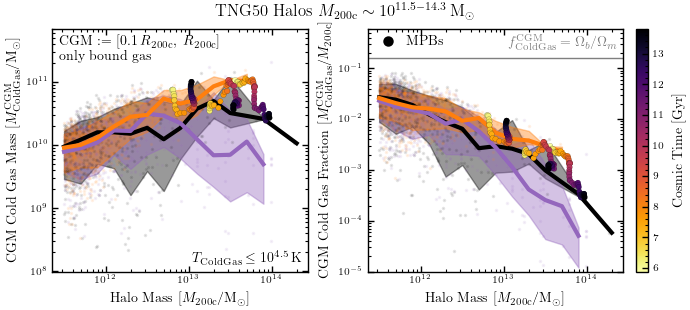

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

colors = ['k', 'tab:purple', 'tab:orange']

for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]
    result1_dict = result1[snapNum_i]
    color = colors[snapNum_i]

    y_50s = result1_dict[50]
    mask = y_50s > 0

    y_50s_plot = 10.**(y_50s[mask])
    y_16s_plot = 10.**(result1_dict[16][mask])
    y_84s_plot = 10.**(result1_dict[84][mask])
    x_plot = 10.**(result1_dict['bin_cents'][mask])

    data_points_kwargs = dict(alpha=0.1, ms=1, c=color, zorder=1.9)
    medians_kwargs = dict(ls='-', lw=3, marker='None', c=color, zorder=2)
    sigma_kwargs = dict(color=color, alpha=0.4)

    ax.plot(x_plot, y_50s_plot, **medians_kwargs)
    ax.fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    ax.plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasMass_snapNum%03d'%snapNum], **data_points_kwargs)
    
    result2_dict = result2[snapNum_i]

    y_50s_plot = 10.**(result2_dict[50][mask])
    y_16s_plot = 10.**(result2_dict[16][mask])
    y_84s_plot = 10.**(result2_dict[84][mask])
    x_plot = 10.**(result2_dict['bin_cents'][mask])

    axs[1].plot(x_plot, y_50s_plot, **medians_kwargs)
    axs[1].fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    axs[1].plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasFraction_snapNum%03d'%snapNum], **data_points_kwargs)
    

group_indices = [1, 6, 23]
min_snap = 50
for group_index in group_indices:
    group = groups_grp_dict[groups_grp_dict_keys[group_index]]
    SnapNum = group['SnapNum']
    subhalo_indices = group['SubfindID'] >= 0
    Subhalo_CGMCGM = group['SubhaloCGMColdGasMass']
    mask = ((SnapNum >= min_snap) & (subhalo_indices) & (Subhalo_CGMCGM > 0))

    plot_every = -1

    x = group['HostGroup_M_Crit200'][mask][::plot_every]
    y1 = Subhalo_CGMCGM[mask][::plot_every]
    y2 = group['SubhaloCGMColdGasFraction'][mask][::plot_every]
    c = group['CosmicTime'][mask][::plot_every]

    sc_kwargs = dict(c=c, cmap='inferno_r', zorder=3, s=16, edgecolors='black', linewidths=0.1)

    sc = ax.scatter(x, y1, **sc_kwargs)
    sc = axs[1].scatter(x, y2, **sc_kwargs)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(9.9e7, 7.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

text = (r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n'
        'only bound gas')
ax.text(0.025, 0.975, text, ha='left', va='top', transform=ax.transAxes, ma='left')
ax.text(0.975, 0.025, r'$T_{\rm ColdGas} \leq 10^{4.5}\, {\rm K}$', ha='right', va='bottom', transform=ax.transAxes)

ax = axs[1]

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

ax.plot([], [], 'o', label=r'MPBs')
ax.legend(loc='upper left')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

cbar = fig.colorbar(sc, ax=ax, label=r'Cosmic Time [Gyr]')

fig.suptitle(r'TNG50 Halos $M_{\rm 200c} \sim 10^{11.5-14.3}\, {\rm M_\odot}$')

outfname = '%s_CGMCGM-CGMCGf_M200c_allhalos.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')



In [11]:
SnapNums = groups_grp_dict[groups_grp_dict_keys[0]]['SnapNum']


def return_stacked_dict(grp_dict, grp_dict_keys, xdset_key='SnapNum', ydset_key=CGMColdGasMass_key,
                        return_all_profiles=False, return_color_dset=False):
    """
    Given the grp_dict_keys and the implicit grp_dict, stack the ydset_key for all of the
    keys at xdset_key. Optionally returns all profiles and a color dset.
    """
    group0 = grp_dict[grp_dict_keys[0]]
        
    result_dict = {}
 
    # initalize the outputs
    result_dict[50] = np.zeros((len(grp_dict_keys), len(SnapNums)), dtype=group0[ydset_key].dtype) - 1.
    result_dict[16] = result_dict[50].copy()
    result_dict[84] = result_dict[50].copy()  
    result = np.zeros((len(grp_dict_keys), len(SnapNums)), dtype=group0[ydset_key].dtype) - 1.

    if return_color_dset:
        if return_color_dset in group0.keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=group0[return_color_dset].dtype) - 1
        else:
            print('Error return_color_dset %s not available in'%return_color_dset, group0.keys())
            raise ValueError

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]

        subhalo_indices = group['SubfindID'] >= 0
        redshift = group['Redshift'][subhalo_indices]
        
        xdset = group[xdset_key][subhalo_indices]
        ydset = group[ydset_key][subhalo_indices]
        mask = (ydset > 0) & (redshift < 3.1)

        # smooth over big jumps
        y_rm = ru.RunningMedian(ydset[mask], 3)

        ydset_func = interp1d(xdset[mask], y_rm, bounds_error=False, fill_value=0)
        result[index,:] = ydset_func(SnapNums)

        if return_color_dset:
            # assumes value of interest is at z=0, index, 0
            color_dset[index] = group[return_color_dset][0]
        
    # finish loop of indices, save final results
    result = np.ma.masked_values(result, -1)
    
    result_dict[50] = np.median(result, axis=0)
    result_dict[16] = np.percentile(result, 16, axis=0)
    result_dict[84] = np.percentile(result, 84, axis=0) 
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, result, color_dset
        else:
            return result_dict, result
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict
        
def add_redshift_sincez2(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


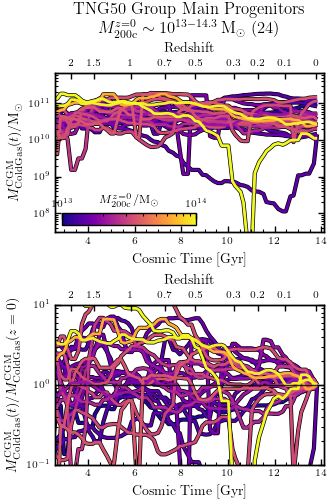

In [12]:
result_dict, result, color_dset = return_stacked_dict(groups_grp_dict, groups_grp_dict_keys, 
                                                      return_all_profiles=True, return_color_dset='HostGroup_M_Crit200')

ys = []
for row in range(result.shape[0]):
    ys.append(result[row])
xs = [groups_grp_dict[groups_grp_dict_keys[0]]['CosmicTime'].tolist()] * len(ys)
c = color_dset.tolist()

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2.7))
ax = axs[0]
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / {\rm M_\odot}$')
ax.set_xlabel(r'Cosmic Time [Gyr]')

lc_kwargs = dict(cmap='plasma', norm=mpl.colors.LogNorm(vmin=10.**(13), vmax=10.**(14)),
                 path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

lc = ru.multiline(xs[::-1], ys[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(2.75, 14.05)
ax.set_ylim(3e7, 7.0e11)
ax = add_redshift_sincez2(ax)

cax = inset_axes(ax, width='50%', height='7.5%', loc='lower left')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'$M_{\rm 200c}^{z=0} / {\rm M_\odot}$', labelpad=-3, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax = axs[1]

ys_norm = []
for y in ys:
    ys_norm.append(y / y[0])

lc = ru.multiline(xs[::-1], ys_norm[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(axs[0].get_xlim())
ax.set_ylim(1.0e-1, 1.0e1)
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / M_{\rm ColdGas}^{\rm CGM}(z=0)$')
ax.set_xlabel(r'Cosmic Time [Gyr]')
ax = add_redshift_sincez2(ax, label=True)
ax.axhline(1.0, ls='-', marker='None', zorder=3, lw=1, c='k', alpha=0.8)

axs[0].set_title('TNG50 Group Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$ (%d)'%len(xs))

fname = '%s_CGMCGM-CGMCGMt-CGMCGMz0_CosmicTime_onlygroups.pdf'%sim
if savefig:
    fig.savefig(outdirec + fname, bbox_inches='tight')


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


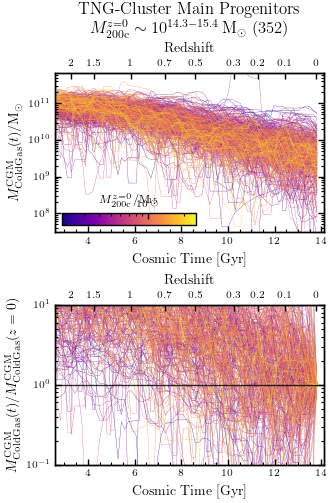

In [13]:

result_dict, result, color_dset = return_stacked_dict(TNGCluster_grp_dict, list(TNGCluster_grp_dict.keys()), 
                                                      return_all_profiles=True, return_color_dset='HostGroup_M_Crit200')

ys = []
for row in range(result.shape[0]):
    ys.append(result[row])
xs = [groups_grp_dict[groups_grp_dict_keys[0]]['CosmicTime'].tolist()] * len(ys)
c = color_dset.tolist()

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2.7))
ax = axs[0]
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / {\rm M_\odot}$')
ax.set_xlabel(r'Cosmic Time [Gyr]')

lc_kwargs = dict(cmap='plasma', linewidths=0.2, norm=mpl.colors.LogNorm(vmin=10.**(14.3), vmax=10.**(15.4)))
                 #path_effects=[pe.Stroke(linewidth=0.5, foreground='k'), pe.Normal()])

lc = ru.multiline(xs[::-1], ys[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(2.75, 14.05)
ax.set_ylim(3e7, 7.0e11)
ax = add_redshift_sincez2(ax)

cax = inset_axes(ax, width='50%', height='7.5%', loc='lower left')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'$M_{\rm 200c}^{z=0} / {\rm M_\odot}$', labelpad=-3, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax = axs[1]

ys_norm = []
for y in ys:
    ys_norm.append(y / y[0])

lc = ru.multiline(xs[::-1], ys_norm[::-1], c[::-1], ax=ax, **lc_kwargs)
ax.set_xlim(axs[0].get_xlim())
ax.set_ylim(1.0e-1, 1.0e1)
ax.set_yscale('log')
ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm CGM}(t) / M_{\rm ColdGas}^{\rm CGM}(z=0)$')
ax.set_xlabel(r'Cosmic Time [Gyr]')
ax = add_redshift_sincez2(ax, label=True)
ax.axhline(1.0, ls='-', marker='None', zorder=3, lw=1, c='k', alpha=0.8)

axs[0].set_title('TNG-Cluster Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (%d)'%len(xs))

fname = '%s_CGMCGM-CGMCGMt-CGMCGMz0_CosmicTime_onlygroups.pdf'%'TNG-Cluster'
if savefig:
    fig.savefig(outdirec + fname, bbox_inches='tight')


/tmp/ipykernel_33753/2990279224.py:46: RuntimeWarning: divide by zero encountered in log10
  bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y1_key]), binwidth)
/tmp/ipykernel_33753/2990279224.py:48: RuntimeWarning: divide by zero encountered in log10
  bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y2_key]), binwidth)


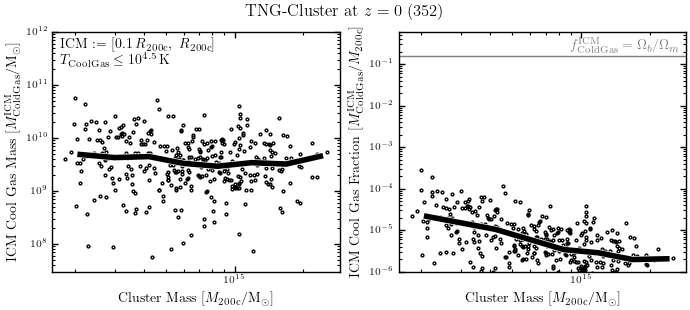

In [14]:
snapNum = 99
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e7, 1.0e12)

ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'ICM Cool Gas Mass $[M_{\rm ColdGas}^{\rm ICM} / {\rm M_\odot}]$')

text = (r'ICM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 
        r'$T_{\rm CoolGas} \leq 10^{4.5}\, {\rm K}$')
ax.text(0.025, 0.975, text, ha='left', va='top',  ma='left', transform=ax.transAxes)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'ICM Cool Gas Fraction $[M_{\rm ColdGas}^{\rm ICM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-6, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm ICM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')


snapNums = [99]
colors = ['k']
for snapNum_i, snapNum in enumerate(snapNums):
    color = colors[snapNum_i]

    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
    plot_kwargs = dict(c=color, marker='o', fillstyle='none', ms=2, mew=1.0)
    axs[0].plot(TNGCluster_tau_dict[x_key], TNGCluster_tau_dict[y1_key], **plot_kwargs)
    axs[1].plot(TNGCluster_tau_dict[x_key], TNGCluster_tau_dict[y2_key], **plot_kwargs)

    binwidth = 0.15
    med_kwargs = dict(marker='None', ls='-', color=color, lw=4, path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])
    bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y1_key]), binwidth)
    axs[0].plot(10.**(bin_cents), 10.**(bin_meds), **med_kwargs)
    bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y2_key]), binwidth)
    axs[1].plot(10.**(bin_cents), 10.**(bin_meds), **med_kwargs)

fig.suptitle(r'TNG-Cluster at $z=0$ (%d)'%TNGCluster_tau_dict[x_key].size)

cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom', ['k', 'tab:purple', 'tab:orange'])
bounds = np.linspace(-0.5, 2.5, 4)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
redshifts = [0.0, 0.5, 2.0]
colors = ['k', 'tab:purple', 'tab:orange']

#cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap), ax=axs[1], label='Redshift')
#cbar.set_ticks(redshifts)
#cbar.set_ticklabels(['0', '0.5', '2'])
#cbar.ax.minorticks_off()

outfname = '%s/%s_ICMCGM-ICMCGf_M200c_snapNum099.pdf'%('TNG-Cluster', 'TNG-Cluster')
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')


/tmp/ipykernel_33753/337874403.py:62: RuntimeWarning: divide by zero encountered in log10
  bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y1_key]), binwidth)
/tmp/ipykernel_33753/337874403.py:64: RuntimeWarning: divide by zero encountered in log10
  bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y2_key]), binwidth)


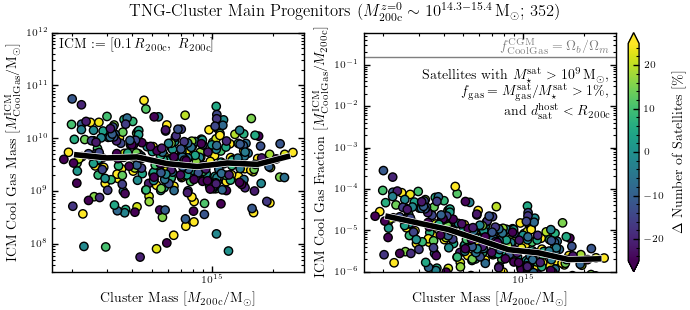

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e7, 1.0e12)

ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'ICM Cool Gas Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$')

ax.text(0.025, 0.975, r'ICM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]', ha='left', va='top', transform=ax.transAxes)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'ICM Cool Gas Fraction $[M_{\rm CoolGas}^{\rm ICM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-6, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm CoolGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

text = (r'Satellites with $M_\star^{\rm sat} > 10^9\, {\rm M_\odot}$,' + '\n' +
        r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
        r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')

ax.text(0.975, 0.85, text, ha='right', va='top', ma='right', transform=ax.transAxes)

snapNums = [99, 67, 33]
markers = ['o', '^', 's']
edgecolors = colors
redshifts = [0, 0.5, 1.0]
Nsats_key = Nsats_total_key
c = TNGCluster_tau_dict[Nsats_key+'_snapNum%03d'%99]
sc_kwargs = dict(norm=mpl.colors.Normalize(vmin=-25, vmax=25))
for snapNum_i, snapNum in enumerate(snapNums): 

    if snapNum_i != 0:
        continue

    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
    c_key = 'Nsatellites_total'+'_snapNum%03d'%snapNum
    c = TNGCluster_tau_dict[Nsats_key + '_snapNum%03d'%snapNum] + 1
    _c = np.log10(TNGCluster_tau_dict[Nsats_key +'_snapNum%03d'%snapNum])
    bin_cents, bin_meds, _ , _ = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), _c, binwidth)
    _c_interp = np.interp(np.log10(TNGCluster_tau_dict[x_key]), bin_cents, bin_meds)
    c = (10.**(_c) - 10.**(_c_interp)) / 10.**(_c) * 100.
    
    x = TNGCluster_tau_dict[x_key]
    sc = axs[0].scatter(x, TNGCluster_tau_dict[y1_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)
    sc = axs[1].scatter(x, TNGCluster_tau_dict[y2_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

    _med_kwargs = med_kwargs.copy()
    _med_kwargs['color'] = edgecolors[snapNum_i]
    bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y1_key]), binwidth)
    axs[0].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)
    bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(TNGCluster_tau_dict[x_key]), np.log10(TNGCluster_tau_dict[y2_key]), binwidth)
    axs[1].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)

    axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %.1f$'%redshifts[snapNum_i], fillstyle='none', mec=edgecolors[snapNum_i])

    """
    order = np.argsort(x)
    sigma = 5
    x_g1d = ndimage.gaussian_filter1d(x[order], sigma)
    y1_g1d = ndimage.gaussian_filter1d(TNGCluster_tau_dict[y1_key][order], sigma)
    y2_g1d = ndimage.gaussian_filter1d(TNGCluster_tau_dict[y2_key][order], sigma)

    smooth_kwargs = dict(marker='None', ls='-', path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])
    axs[0].plot(x_g1d, y1_g1d, c=colors[snapNum_i], **smooth_kwargs)
    axs[1].plot(x_g1d, y2_g1d, c=colors[snapNum_i], **smooth_kwargs)

    axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %.1f$'%redshifts[snapNum_i], fillstyle='none', mec=edgecolors[snapNum_i])
    """

    continue

#axs[0].legend(loc = 'lower left')

fig.suptitle(r'TNG-Cluster Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$; %d)'%x.size)

cbar = fig.colorbar(sc, ax=ax, label=r'$\Delta$ Number of Satellites [$\%$]', extend='both')

outfname = '%s/%s_ICMCGM-ICMCGf_M200c_Nsatellties-onlymassive_Evolution.pdf'%('TNG-Cluster', 'TNG-Cluster')
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')


In [16]:
np.mean(c), np.median(c)

(1.5982778202386831, 1.678892437204078)

In [17]:
TNGCluster_tau_dict.keys()


dict_keys(['SubfindID', 'HostSubhaloGrNr', 'SnapNum_snapNum099', 'SnapNum_snapNum067', 'SnapNum_snapNum050', 'SnapNum_snapNum033', 'SnapNum_snapNumBHRMFirstSnap', 'CosmicTime_snapNum099', 'CosmicTime_snapNum067', 'CosmicTime_snapNum050', 'CosmicTime_snapNum033', 'CosmicTime_snapNumBHRMFirstSnap', 'HostGroup_M_Crit200_snapNum099', 'HostGroup_M_Crit200_snapNum067', 'HostGroup_M_Crit200_snapNum050', 'HostGroup_M_Crit200_snapNum033', 'HostGroup_M_Crit200_snapNumBHRMFirstSnap', 'HostGroup_R_Crit200_snapNum099', 'HostGroup_R_Crit200_snapNum067', 'HostGroup_R_Crit200_snapNum050', 'HostGroup_R_Crit200_snapNum033', 'HostGroup_R_Crit200_snapNumBHRMFirstSnap', 'SubhaloMass_snapNum099', 'SubhaloMass_snapNum067', 'SubhaloMass_snapNum050', 'SubhaloMass_snapNum033', 'SubhaloMass_snapNumBHRMFirstSnap', 'Subhalo_Mstar_Rgal_snapNum099', 'Subhalo_Mstar_Rgal_snapNum067', 'Subhalo_Mstar_Rgal_snapNum050', 'Subhalo_Mstar_Rgal_snapNum033', 'Subhalo_Mstar_Rgal_snapNumBHRMFirstSnap', 'Subhalo_Rgal_snapNum099', 

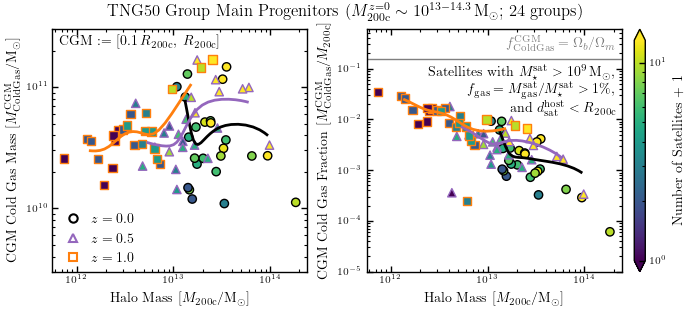

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e9, 3.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

ax.text(0.025, 0.975, r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]', ha='left', va='top', transform=ax.transAxes)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

text = (r'Satellites with $M_\star^{\rm sat} > 10^9\, {\rm M_\odot}$,' + '\n' +
        r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
        r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')

ax.text(0.975, 0.85, text, ha='right', va='top', ma='right', transform=ax.transAxes)


markers = ['o', '^', 's']
edgecolors = colors
redshifts = [0, 0.5, 1.0]
c = groups_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%99]
sc_kwargs = dict(norm=mpl.colors.LogNorm(vmin=1, vmax=np.percentile(c,95)))
for snapNum_i, snapNum in enumerate(snapNums): 
    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
    c = groups_tau_dict[Nsats_onlymassive_key+'_snapNum%03d'%snapNum] + 1
    x = groups_tau_dict[x_key]
    sc = axs[0].scatter(x, groups_tau_dict[y1_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)
    sc = axs[1].scatter(x, groups_tau_dict[y2_key], marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

    order = np.argsort(x)
    sigma = 3
    x_g1d = ndimage.gaussian_filter1d(x[order], sigma)
    y1_g1d = ndimage.gaussian_filter1d(groups_tau_dict[y1_key][order], sigma)
    y2_g1d = ndimage.gaussian_filter1d(groups_tau_dict[y2_key][order], sigma)

    smooth_kwargs = dict(marker='None', ls='-')
    axs[0].plot(x_g1d, y1_g1d, c=colors[snapNum_i], **smooth_kwargs)
    axs[1].plot(x_g1d, y2_g1d, c=colors[snapNum_i], **smooth_kwargs)

    axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %.1f$'%redshifts[snapNum_i], fillstyle='none', mec=edgecolors[snapNum_i])

    continue

axs[0].legend(loc = 'lower left')

fig.suptitle(r'TNG50 Group Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$; %d groups)'%x.size)

cbar = fig.colorbar(sc, ax=ax, label=r'Number of Satellites + 1', extend='both')

outfname = '%s_CGMCGM-CGMCGf_M200c_Nsatellties-onlymassive_onlygroups.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')



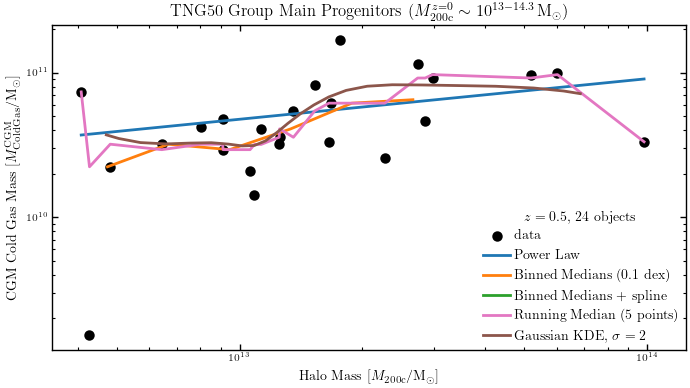

In [19]:
# consider different ways to show statistical trends
x_key = 'HostGroup_M_Crit200_snapNum%03d'%67
y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%67

x = groups_tau_dict[x_key]
y = groups_tau_dict[y1_key]

def power_law(x, slope, norm):
    return norm * x**slope

popt, pcov = curve_fit(power_law, x, y)

bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(x), np.log10(y), binwidth)

N_smooth = 200

x_bin = 10.**(bin_cents)
y50s_bin = 10.**(bin_meds)
x_smooth = np.linspace(x_bin.min(), x_bin.max(), N_smooth)
tck = interpolate.splrep(x_bin, y50s_bin)
y50s_smooth = interpolate.splev(x_smooth, tck)

argsort = np.argsort(x)
N_RM = 5
y_RM = ru.RunningMedian(y[argsort], N_RM)

sigma = 2
x_g1d = ndimage.gaussian_filter1d(x[argsort], sigma)
y_g1d = ndimage.gaussian_filter1d(y[argsort], sigma)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

# plot data
ax.plot(x, y, label=r'data')

# plot smoothed data
smooth_kwargs = dict(marker='None', ls='-')
x_plot = [x.min(), x.max()]
ax.plot(x_plot, power_law(x_plot, *popt), label=r'Power Law', **smooth_kwargs)
ax.plot(x_bin, y50s_bin, label=r'Binned Medians (%.1f dex)'%binwidth, **smooth_kwargs)
ax.plot(x_smooth, y50s_smooth, label=r'Binned Medians + spline', **smooth_kwargs)
ax.plot(x[argsort], y_RM, label=r'Running Median (%d points)'%N_RM, **smooth_kwargs)
ax.plot(x_g1d, y_g1d, label=r'Gaussian KDE, $\sigma=%d$'%sigma, **smooth_kwargs)

ax.set_title(r'TNG50 Group Main Progenitors ($M_{\rm 200c}^{z=0} \sim 10^{13-14.3}\, {\rm M_\odot}$)')

ax.legend(title=r'$z=0.5$, %d objects'%x.size)

outfname = '%s_CGMCGM_M200c_only_groups_smoothingmethods.pdf'%sim
if savefig:
    fig.savefig(outdirec + outfname, bbox_inches='tight')

In [20]:
sim = 'TNG-Cluster'

M200c_log = np.log10(TNGCluster_tau_dict['HostGroup_M_Crit200_snapNum099'])
mask = ((M200c_log > 14.95) * (M200c_log < 15.05))
SubfindIDs = TNGCluster_tau_dict['SubfindID'][mask]
grp_dict_keys = []
for subfindID in SubfindIDs:
    grp_dict_keys.append('099_%08d'%subfindID)


In [21]:
group.keys()

dict_keys(['CGMTemperaturesHistogram', 'CGMTemperaturesHistogramBincents', 'CosmicTime', 'HostCentricDistance_norm', 'HostCentricDistance_phys', 'HostGroup_M_Crit200', 'HostGroup_R_Crit200', 'HostSubalo_Rgal', 'HostSubfindID', 'HostSubhaloGrNr', 'HostSubhaloPos', 'HostSubhaloVel', 'HostSubhalo_Mstar_Rgal', 'MainBHMass', 'MainBHParticleID', 'MainBH_CumEgyInjection_RM', 'MainBH_RM_FirstSnap', 'NSatellites_Mstar>1.0e10_fgas>0.01_dsathost<R200c', 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c', 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c', 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c', 'Nsatellites_total', 'Redshift', 'SnapNum', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCGMColdGasFraction', 'SubhaloCGMColdGasMass', 'SubhaloColdGasDensityShells', 'SubhaloColdGasMass', 'SubhaloColdGasMassInflowRate0.1R200c', 'SubhaloColdGasMassInflowRateR200c', 'SubhaloColdGasMassOutflowRate0.1R200c', 'SubhaloColdGasMassOutflowRateR200c', 'SubhaloColdGasMassShells', 'SubhaloDMMass', 'Subh

In [22]:
def plot_ICMTemperatureHistrogramEvolution(grp_dict, grp_dict_key, savefig=False):
    group = grp_dict[grp_dict_key]

    ydset_key = 'CGMTemperaturesHistogram'
    xdset_key = 'CGMTemperaturesHistogramBincents'

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))

    start = np.argmin(abs(group['Redshift'] - 3.0))
    end = np.argmin(abs(group['Redshift'] - 0))
    xs = []
    ys = []
    cs = []

    # loop over the snapshots
    for index in np.arange(start, end, -1):
        _x = group[xdset_key][index]
        _y = group[ydset_key][index]
        xs.append(_x)
        ys.append(clean_temp_hist(_x, _y, interp_zero=True, force_zero=True, normalize=True))
        cs.append(group['CosmicTime'][index])
    # end loop over snapshots

    kwargs = dict(path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()],
                cmap='inferno_r', norm=mpl.colors.Normalize())
    lc = ru.multiline(xs, ys, cs, ax=ax, **kwargs)

    # add the colorbar
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical')
    cbar.set_label(r'Cosmic Time [Gyr]', labelpad=5, fontsize='small')

    #ax.plot(bincents, dset / norm, 'k-', marker='None')
    ax.set_yscale('log')
    ax.set_xlabel(r'ICM Gas Temperature [log K]')
    ax.set_ylabel(r'PDF')
    ax.set_ylim(3.0e-6, 5)
    ax.set_xlim(2.75, 9.0)

    ax.set_title(r'TNG-Cluster $z=0$ SubfindID %d'%int(group['SubfindID'][0]), fontsize='medium')

    if savefig:
        sim = 'TNG-Cluster'
        fname = '%s/%s_snap099_subfindID%s_ICMGasTemperatureHistogramEvolution_CosmicTime.pdf'%(sim, sim, group['SubfindID'][0])
        fig.savefig(outdirec + fname, bbox_inches='tight')

    return fig, ax


def clean_temp_hist(bincents, hist, interp_zero=False, force_zero=False, rewrite_sfgas=False, normalize=True):
    """
    clean the temperature histograms of artifacts, namely:
    (1) interpolate zero-values between 10^4 K and maximum temperature
    (2) overwrite temperatures between 10^3 and 10^4 K to be 0
    (3) attribute SF gas to 10^4 K rather than 10^3 K
    (4) Normalize the histogram to create a PDF
    """
    _result = hist.copy()
    binwidth = bincents[1] - bincents[0]
    tolerance = 1.0e-1 # % of binwidth
    if interp_zero:
        bincents_mask = bincents > (4. - binwidth * tolerance)
        zero_mask = hist <= 0
        if _result[bincents_mask & ~zero_mask].size >= 2:
            tempfunc = interp1d(bincents[bincents_mask & ~zero_mask], hist[bincents_mask & ~zero_mask], bounds_error=False, fill_value=0)
            _result[bincents_mask & zero_mask] = tempfunc(bincents[bincents_mask & zero_mask])

    if force_zero:
        bincents_mask = ((bincents > (3. + binwidth * tolerance)) &
                         (bincents < (4. - binwidth * tolerance)))
        _result[bincents_mask] = 0

    if rewrite_sfgas:
        sf_mask = np.argmin(np.abs(bincents - 3.0))
        rewrite_mask = np.argmin(np.abs(bincents - 4.0))
        _result[rewrite_mask] = _result[sf_mask]
        _result[sf_mask] = 0.

    if normalize:
        result = _result / np.sum(_result * binwidth)
    else:
        result = _result

    return result


/tmp/ipykernel_33753/3908007636.py:79: RuntimeWarning: invalid value encountered in true_divide
  result = _result / np.sum(_result * binwidth)


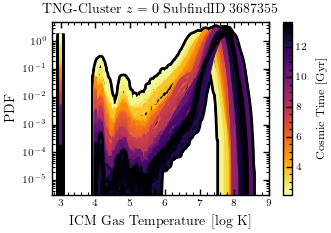

In [23]:
grp_dict = TNGCluster_grp_dict
fig, ax = plot_ICMTemperatureHistrogramEvolution(grp_dict, grp_dict_keys[3], savefig=savefig)

In [24]:

cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom', ['k', 'tab:purple', 'tab:orange'])
bounds = np.linspace(-0.5, 2.5, 4)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
redshifts = [0.0, 0.5, 2.0]
colors = ['k', 'tab:purple', 'tab:orange']

def plot_stacked_temp_dict_evolution(grp_dict, grp_dict_keys, savefig=False,
                                     redshifts=redshifts, colors=colors, cmap=cmap, norm=cmap_norm,
                                     return_color_dset='Redshift', color_dset_log=False):

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
    ax, lc = add_stacked_temp_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                   colors=colors, cmap=cmap, norm=norm, return_color_dset=return_color_dset, color_dset_log=color_dset_log)
    ax.set_yscale('log')
    cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
    cbar.ax.set_yticklabels(['0', '0.5', '2'])
    cbar.ax.minorticks_off()
    cbar.solids.set(alpha=1.0)
    cbar.set_label(r'Redshift', fontsize='small')

    ax.set_ylabel(r'PDF', fontsize='small')
    ax.set_xlabel(r'ICM Gas Temperature [log k]', fontsize='small')
    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ MPBs (%d)'%(len(grp_dict_keys)), fontsize='medium')

    ax.set_ylim(3.0e-6, 5)
    ax.set_xlim(2.75, 9.0)

    if savefig:
        sim = 'TNG-Cluster'
        fname = '%s/%s_M200cz01e15_ICMGasTemperatureHistogramEvolution.pdf'%(sim, sim)
        fig.savefig(outdirec + fname, bbox_inches='tight')
    
    return fig, ax


def plot_stacked_temp_dict_m200c(grp_dict, grp_dict_keys, 
                                 redshift=0., color='k', cmap='viridis', norm=None,
                                 return_color_dset='HostGroup_M_Crit200', color_dset_log=True):


    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
    ax, lc = add_stacked_temp_dict(ax, grp_dict, grp_dict_keys, redshifts=[redshift],
                                   colors=[color], cmap=cmap, norm=norm, return_color_dset=return_color_dset,
                                   color_dset_log=color_dset_log)
    ax.set_yscale('log')
    cbar = fig.colorbar(lc, ax=ax, extend='both')
    if abs(redshift - 0.5) < 1.0e-3:
        z_str = '0.5'
    else:
        z_str = str(int(redshift))

    cbar.set_label(r'Cluster Mass $[\log_{10}(M_{\rm 200c}^{z=%s} / {\rm M_\odot})]$'%z_str, fontsize='small')
    cbar.solids.set(alpha=1.0)
    cbar.minorticks_off()
    ax.set_ylabel(r'PDF', fontsize='small')
    ax.set_xlabel(r'ICM Gas Temperature [log K]', fontsize='small')
    ax.set_title(r'TNG-Cluster MPBs at $z=%s\ (%d)$'%(z_str, len(grp_dict_keys)), fontsize='medium')
    ax.set_ylim(3.0e-6, 5)
    ax.set_xlim(2.75, 9.0)

    return fig, ax, cbar


def plot_stacked_sgrp_dict_m200c(grp_dict, grp_dict_keys, 
                                 redshifts=redshifts, colors=colors, cmap='viridis', norm=None,
                                 return_color_dset='HostGroup_M_Crit200', color_dset_log=True):


    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
    ax, lc = add_stacked_temp_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                   bincents_key='radii', dset_key='SubhaloColdGasMassShells',
                                   colors=colors, cmap=cmap, norm=norm, return_color_dset=return_color_dset,
                                   color_dset_log=color_dset_log)
    ax.set_yscale('log')
    cbar = fig.colorbar(lc, ax=ax, extend='both')
    if abs(redshifts[0] - 0.5) < 1.0e-3:
        z_str = '0.5'
    else:
        z_str = str(int(redshifts[0]))

    cbar.set_label(r'Cluster Mass $[\log_{10}(M_{\rm 200c}^{z=%s} / {\rm M_\odot})]$'%z_str, fontsize='small')
    cbar.solids.set(alpha=1.0)
    cbar.minorticks_off()
    #ax.set_ylabel(r'Cool Gas Density $[{\rm M_\odot\, kpc^{-3}}]$', fontsize='small')
    ax.set_ylabel('External Cool Gas Mass \n' + r'$[M_{\rm CoolGas}(>r) / {\rm M_\odot}]$', fontsize='small')
    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize='small')
    ax.set_title(r'TNG-Cluster MPBs at $z=%s\ (%d)$'%(z_str, len(grp_dict_keys)), fontsize='medium')
    #ax.set_ylim(1.1e-3, 9e7)
    ax.set_ylim(1.0e8, 1.0e12)
    ax.set_xlim(9.0e-3, 3.0)
    add_BCG_ICM_line(ax)

    return fig, ax, cbar
   


def add_stacked_temp_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                          bincents_key='CGMTemperaturesHistogramBincents', dset_key='CGMTemperaturesHistogram',
                          colors=colors, cmap=cmap, norm=cmap_norm,
                          return_color_dset='Redshift', color_dset_log=False):

    result = {}
    for redshift_i, redshift in enumerate(redshifts):
        result[redshift] = {}
        stacked_dict, bincents, hists, color = return_stacked_temp_dict(grp_dict, grp_dict_keys, return_all_profiles=True,
                                                                        dset_key=dset_key, bincents_key=bincents_key,
                                                                        redshift=redshift, return_color_dset=return_color_dset,
                                                                        color_dset_log=color_dset_log)
        result[redshift]['stacked_dict'] = stacked_dict
        result[redshift]['bincents'] = bincents
        result[redshift]['hists'] = hists
        result[redshift]['color'] = color
        result[redshift]['stacked_dict_kwargs'] = dict(path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                                                       marker='None', ls='-', lw=2, c=colors[redshift_i], label=r'$z=%d$'%(int(redshift)))
        result[redshift]['norm_kwargs'] = dict(lw=0.1, alpha=0.5, ls='-', cmap=cmap, norm=norm)

    for redshift_i, redshift in enumerate(redshifts[::-1]):
        _result = result[redshift]
        time_index = np.argmin(np.abs(grp_dict[grp_dict_keys[0]]['Redshift'] - redshift))

        y = _result['stacked_dict']['50']
        x = _result['stacked_dict']['bincents']
        if 'Mass' in dset_key:
            mask = y > 0
        else: 
            mask = x > 0
        ax.plot(x[mask], y[mask], **_result['stacked_dict_kwargs'])

        _hists = _result['hists']
        _bincents = _result['bincents']
        ys = []
        xs = []
        cs = []
        for y_i, y in enumerate(_hists):
            if grp_dict[grp_dict_keys[y_i]]['SubfindID'][time_index] < 0:
                continue
            if 'Mass' in dset_key:
                mask = y > 0
            else: 
                mask = x > 0
            x = _bincents[y_i][mask]
            xs.append(x)
            ys.append(y[mask])
            cs.append(_result['color'][y_i])

        if not norm:
            vmin = np.percentile(cs, 5)
            vmax = np.percentile(cs, 95)
            if color_dset_log:
                _result['norm_kwargs']['norm'] = mpl.colors.Normalize(vmin, vmax)
            else:
                _result['norm_kwargs']['norm'] = mpl.colors.LogNorm(vmin, vmax)
        
        lc = ru.multiline(xs, ys, cs, ax=ax, **_result['norm_kwargs'])

    return ax, lc


def return_stacked_temp_dict(grp_dict, grp_dict_keys, dset_key='CGMTemperaturesHistogram', bincents_key='CGMTemperaturesHistogramBincents',
                             redshift=0., return_all_profiles=False, return_color_dset=False, color_dset_log=False):
    """
    Given the grp_dict_keys and the implicit grp_dict, stack the dset_key for all of the
    keys at the given time, which must match be either z0 or a tau definition, such as tau_infall_mass
    """
        
    result_dict = {}
 
    # initalize the outputs
    _bincents = np.zeros((len(grp_dict_keys), len(grp_dict[grp_dict_keys[0]][bincents_key][0])), dtype=float) - 1   
    _hists = _bincents.copy() 

    if return_color_dset:
        if return_color_dset in grp_dict[grp_dict_keys[0]].keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=grp_dict[grp_dict_keys[0]][return_color_dset].dtype) - 1
        else:
            print('return_color_dset %s not recognized. Please choose from the following'%return_color_dset)
            print(grp_dict[grp_dict_keys[0]].keys())
            raise KeyError()

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]
        time_index = np.argmin(abs(group['Redshift'] - redshift))
        if group['SubfindID'][time_index] < 0:
            continue
        if return_color_dset:
            if color_dset_log:
                color_dset[index] = np.log10(group[return_color_dset][time_index])
            else:
                color_dset[index] = group[return_color_dset][time_index]
        _bincents[index,:] = group[bincents_key][time_index]
        _hist = group[dset_key][time_index]
        if np.sum(_hist) <= 0:
            continue
        
        if 'Temp' in dset_key:
            _hists[index,:] = clean_temp_hist(_bincents[index,:], _hist, interp_zero=True, force_zero=True)
        elif 'Mass' in dset_key:
            result = compute_massext_profile(group, dset_key, time_index, norm='r200c')
            _bincents[index,:] = result[0]
            _hists[index,:] = result[1]

    # finish loop of indices, save final results
    bincents = np.ma.masked_values(_bincents, -1)
    hists = np.ma.masked_values(_hists, -1)

    result_dict['50'] = np.median(hists, axis=0)
    result_dict['16'] = np.percentile(hists, 16, axis=0)
    result_dict['84'] = np.percentile(hists, 84, axis=0) 
    result_dict['Ngal'] = len(hists)
    result_dict['bincents'] = np.median(bincents, axis=0)
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, bincents, hists, color_dset
        else:
            return result_dict, bincents, hists
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict


def compute_massext_profile(group, dset_key, time_index, norm='rhalfstar'):
    """
    Compute and return the external mass profile for group and the given dset_key
    at time time_index. Normalizes the radial coordinates by norm.
    """
    masses = group[dset_key][time_index]
    _radii = group['radii'][time_index]
    if 'rhalfstar' == norm:
        rmin = -1.0 # log(r / rgal)
        rmax = np.log10(5.0e2) # log(r / rgal)
        rnorm = group['Subhalo_Rgal'][time_index] / 2.0 
    elif 'r200c' == norm:
        rmin = -2.0 # log(r / r200c)
        rmax = np.log10(3.0) # log(r / r200c)
        rnorm = group['HostGroup_R_Crit200'][time_index]
    else:
        rmin = 0.0 # log(kpc)
        rmax = np.log10(3.0e3) #log(kpc) 
        rnorm = 1.0
    radii_save = np.logspace(rmin, rmax, _radii.size)
    radii = _radii / rnorm
    _masses_extsum = np.cumsum(masses[::-1])[::-1]
    massfunc = interp1d(radii, _masses_extsum, bounds_error=False, fill_value=0)
    masses_extsum = massfunc(radii_save)

    return radii_save, masses_extsum


def compute_dens_profile(group, dset_key, time_index, norm='rhalfstar'):
    """ 
    Compute and return the density profile using the masses and radii
    Returns the radii and density profile, default normalized to R_half,star
    """
    
    masses = group[dset_key][time_index]
    _radii = group['radii'][time_index]
    volumes = group['vol_shells'][time_index]
    if 'rhalfstar' == norm:
        rmin = -1.0 # log(r / rgal)
        rmax = np.log10(5.0e2) # log(r / rgal)
        rnorm = group['Subhalo_Rgal'][time_index] / 2.0 
    elif 'r200c' == norm:
        rmin = -2.0 # log(r / r200c)
        rmax = np.log10(3.0) # log(r / r200c)
        rnorm = group['HostGroup_R_Crit200'][time_index]
    else:
        rmin = 0.0 # log(kpc)
        rmax = np.log10(3.0e3) #log(kpc) 
        rnorm = 1.0
    radii_save = np.logspace(rmin, rmax, _radii.size)
    mask = masses > 1.0e3
    radii = _radii / rnorm
    if mask[mask].size < 2:
        return radii, np.zeros(radii.size, dtype=masses.dtype) - 1
    
    # interpolate the non0 masses, and write the values outside of the bounds as 0
    massfunc = interp1d(radii[mask], masses[mask], bounds_error=False, fill_value=0)
    densities = massfunc(radii) / volumes
    densities_model = interp1d(radii, densities, bounds_error=False, fill_value=0)
    densities = densities_model(radii_save)

    return radii_save, densities

def add_BCG_ICM_line(ax, norm='r200c', 
                     grp_dict=None, grp_dict_keys=None, redshifts=None, colors=None):
    """ add the demarcating line between the BCG and ICM to ax at xval """

    if norm == 'r200c':
        ax.axvline(0.1, c='black', ls='--', marker='None')
        ax.axvline(1.0, c='black', ls='--', marker='None')

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        
        annotate_kwargs = dict(xytext=((0.09),(0.05)), xycoords=trans,
                            arrowprops=dict(facecolor='tab:gray', shrink=0.05),
                            fontsize='medium', ha='right', va='center', c='black')
        ax.annotate('', (0.02, 0.05), **annotate_kwargs)
        ax.text(0.09, 0.075, r'BCG', transform=trans, ha='right', va='bottom', c='black')

        annotate_kwargs = dict(xycoords=trans,
                            fontsize='medium', ha='left', va='center', c='black',
                                arrowprops=dict(facecolor='tab:gray', lw=4,
                                                arrowstyle='<|-|>'))
        ax.annotate('', xy=(0.1,0.05), xytext=((1.0),(0.05)),  **annotate_kwargs)
        ax.text(0.13, 0.075, r'ICM', transform=trans, ha='left', va='bottom', c='black')

    else:
        # input validations
        if not isinstance(grp_dict_keys, list):
            grp_dict_keys = [grp_dict_keys]
        assert len(redshifts) == len(colors), KeyError('len(redshifts) != len(colors)')
        for redshift_i, redshift in enumerate(redshifts):
            rmins = np.zeros(len(grp_dict_keys), dtype=float) - 1.
            rmaxs = rmins.copy()

            for grp_dict_key_i, grp_dict_key in enumerate(grp_dict_keys):
                group = grp_dict[grp_dict_key]
                redshift_index = np.argmin(abs(group['Redshift'] - redshift))
                r200c = group['HostGroup_R_Crit200'][redshift_index]
                if norm == 'rhalfstar':
                    rhalfstar = group['Subhalo_Rgal'][redshift_index] / 2.0
                    rmins[grp_dict_key_i] = (0.1 * r200c) / rhalfstar
                    rmaxs[grp_dict_key_i] = r200c / rhalfstar
                else:
                    rmins[grp_dict_key_i] = 0.1 * r200c
                    rmaxs[grp_dict_key_i] = r200c

            # finish loop over grp_dict_keys
            xmin = np.median(rmins)
            xmax = np.median(rmaxs)

            kwargs = dict(ymin=0.9, marker='None', lw=2, color=colors[redshift_i], zorder=3.1)
            ax.axvline(xmin, ls='-', **kwargs)
            ax.axvline(xmax, ls='-', **kwargs)
    
    return ax



/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


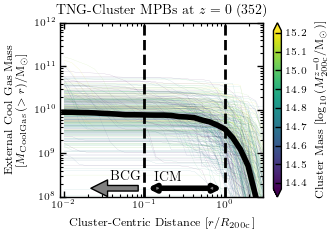

In [25]:
redshift = [0.]
color = ['k']
norm = 'r200c'
fig, ax, cbar = plot_stacked_sgrp_dict_m200c(grp_dict, TNGCluster_grp_dict_keys, redshifts=redshift, colors=color)
ax.set_xscale('log')

if savefig:
    fname = '%s/%s_CoolGasExternalRadialProfile_redshift%.1f.pdf'%(sim, sim, redshift)
    fig.savefig(outdirec + fname)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


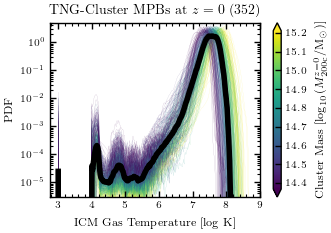

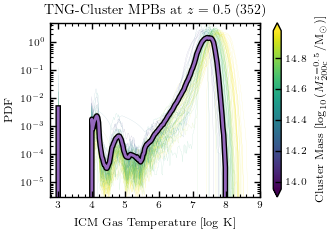

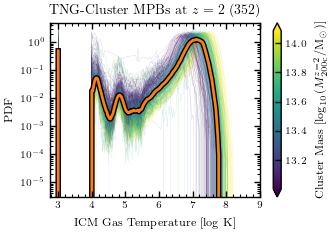

In [26]:
redshifts = [0.0, 0.5, 2.0]
colors = ['k', 'tab:purple', 'tab:orange']
for redshift_i, redshift in enumerate(redshifts):
    color = colors[redshift_i]
    fig, ax, cbar = plot_stacked_temp_dict_m200c(grp_dict, TNGCluster_grp_dict_keys, redshift=redshift, color=color)
    if True:
        fname = '%s/%s_ICMGasTemperatureHistogram_redshift%.1f.pdf'%(sim, sim, redshift)
        fig.savefig(outdirec + fname)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


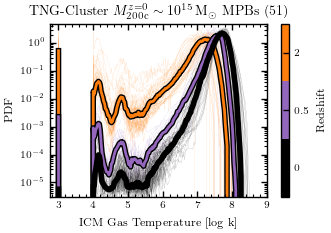

In [27]:
fig, ax = plot_stacked_temp_dict_evolution(grp_dict, grp_dict_keys, savefig=savefig)

Text(0, 0.5, 'ICM Cool Gas Mass')

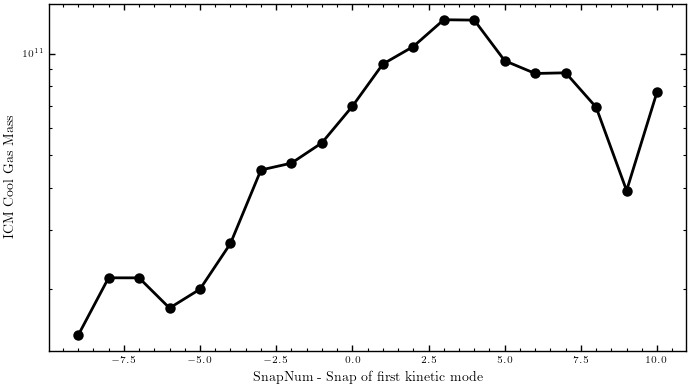

In [69]:
group = TNGCluster_grp_dict[TNGCluster_grp_dict_keys[100]]
MainBH_RM_FirstSnap = group['MainBH_RM_FirstSnap']
time_index = np.where(MainBH_RM_FirstSnap == group['SnapNum'])[0][0]
Nsnaps = 10

SnapNums = group['SnapNum'][time_index-Nsnaps:time_index+Nsnaps] - MainBH_RM_FirstSnap
ICMCGM = group['SubhaloCGMColdGasMass'][time_index-Nsnaps:time_index+Nsnaps]
MainBH_CumEgyInjection_RM = group['MainBH_CumEgyInjection_RM'][time_index-Nsnaps:time_index+Nsnaps]

fig, ax = plt.subplots()
ax.plot(SnapNums, ICMCGM, ls='-')
ax.set_yscale('log')
ax.set_xlabel(r'SnapNum - Snap of first kinetic mode')
ax.set_ylabel(r'ICM Cool Gas Mass')


In [70]:
MainBH_CumEgyInjection_RM

array([8.00908379e+58, 4.82437769e+58, 1.57280296e+58, 1.70224013e+57,
       6.69571255e+55, 1.56723552e+51, 8.99247367e+50, 6.04706067e+50,
       2.02578412e+50, 1.89576129e+50, 1.72435709e+50, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [28]:

cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom', ['k', 'tab:purple', 'tab:orange'])
bounds = np.linspace(-0.5, 2.5, 4)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
redshifts = [0.0, 0.5, 2.0]
colors = ['k', 'tab:purple', 'tab:orange']

def plot_SGRPevolution(grp_dict, grp_dict_key, clf=False, 
                       norm='r200c'):
    """
    Plot in two panels the evolution of hot and cold gas radial profiles.
    Start at the time of peak hot and cold gas mass and plot until there 
    is no more gas. Include some extra info in each panel about the 
    given subhalo.
    """
    
    group = grp_dict[grp_dict_key]

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
    cmap = 'inferno_r'

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1.1e-3, 9e7)

    if norm == 'r200c':
        add_BCG_ICM_line(ax)
        ax.set_xlim(9.0e-3, 2.0)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize='small')
    elif norm == 'rhalfstar':
        add_BCG_ICM_line(ax, norm=norm, 
                         grp_dict=grp_dict, grp_dict_keys=[grp_dict_key], redshifts=redshifts, colors=colors)
        ax.set_xlim(7.0e-1, 5.0e2)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm half,\star}^{\rm BCG}]$', fontsize='small')
    else:
        add_BCG_ICM_line(ax, norm=norm, 
                         grp_dict=grp_dict, grp_dict_keys=[grp_dict_key], redshifts=redshifts, colors=colors)
        ax.set_xlim(1.0, 3.0e3)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / {\rm pkpc}]$', fontsize='small')

    ax.set_ylabel(r'Cold Gas Density $[{\rm M_\odot\, kpc^{-3}}]$', fontsize='small')

    ax.set_title(r'TNG-Cluster $z=0$ SubfindID %d'%int(group['SubfindID'][0]), fontsize='medium')
    text = (r'$\lg M_{\rm 200c} = %.1f$'%(np.log10(group['HostGroup_M_Crit200'][0])) + '\n' + 
            r'$\lg M_{\star}^{\rm BCG} = %.1f$'%(np.log10(group['Subhalo_Mstar_Rgal'][0])))
    ax.text(0.05, 0.15, text, ha='left', va='bottom', ma='left', transform=ax.transAxes, fontsize='small')
        
    start = np.argmin(abs(group['Redshift'] - 3.0))
    end = np.argmin(abs(group['Redshift'] - 0))

    xs = []
    ys = []
    cs = []
    
    # loop over the snapshots
    for index in range(start, end, -1):
        x, y = compute_dens_profile(group, 'SubhaloColdGasMassShells', index, norm=norm)
        plot_indices = y > 0
        xs.append(x[plot_indices])
        ys.append(y[plot_indices])
        cs.append(group['CosmicTime'][index])  
    # end loop over snapshots
    kwargs = dict(path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()],
                  cmap=cmap)

    lc = ru.multiline(xs, ys, cs, ax=ax, **kwargs)
    
    # add the colorbar
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical')
    cbar.set_label('Cosmic Time [Gyr]', labelpad=5, fontsize='small')
        
    if clf:
        plt.close(fig)
        return
            
    return fig, ax


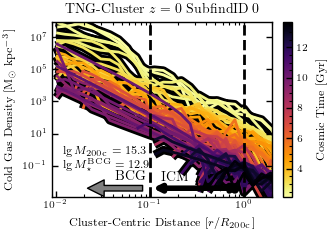

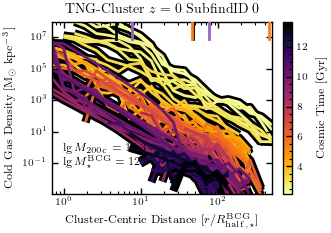

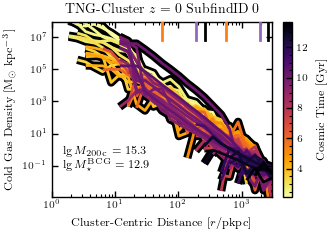

In [29]:
fig, ax = plot_SGRPevolution(TNGCluster_grp_dict, TNGCluster_grp_dict_keys[0], norm='r200c')

fig, ax = plot_SGRPevolution(TNGCluster_grp_dict, TNGCluster_grp_dict_keys[0], norm='rhalfstar')

fig, ax = plot_SGRPevolution(TNGCluster_grp_dict, TNGCluster_grp_dict_keys[0], norm=None)

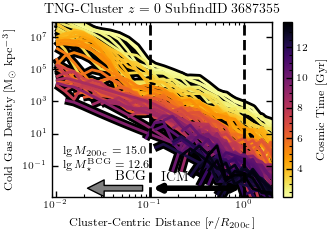

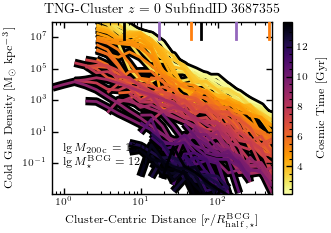

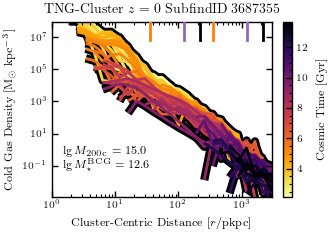

In [30]:
norms = ['r200c', 'rhalfstar', None]
for norm in norms:
    fig, ax = plot_SGRPevolution(TNGCluster_grp_dict, grp_dict_keys[3], norm=norm)
    if savefig:
        fname = '%s/TNG-Cluster_snap099_haloID%08d_ColdGasRadProfileEvolution_%s.pdf'%(sim, TNGCluster_grp_dict[grp_dict_keys[3]]['SubfindID'][0], norm)
        fig.savefig(outdirec + fname, bbox_inches='tight')




In [31]:
sim = 'TNG-Cluster'
grp_dict = TNGCluster_grp_dict

"""
_cmap = plt.cm.inferno
_cmaplist = [_cmap(i) for i in range(_cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('inferno_r_custom', _cmaplist, _cmap.N)
bounds = np.linspace(-0.5, 2.5, 4)
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
"""

cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom', ['k', 'tab:purple', 'tab:orange'])
bounds = np.linspace(-0.5, 2.5, 4)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
redshifts = [0.0, 0.5, 2.0]
colors = ['k', 'tab:purple', 'tab:orange']

def plot_stacked_dict(grp_dict_keys, norm='r200c',
                      redshifts=redshifts, colors=colors, cmap=cmap, return_color_dset='Redshift'):

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
    ax, lc = add_stacked_dict(ax, grp_dict_keys, norm=norm, redshifts=redshifts, colors=colors, cmap=cmap, return_color_dset=return_color_dset)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if redshifts == [0., 0.5, 2.0]:
        cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
        cbar.ax.set_yticklabels(['0', '0.5', '2'])
        cbar.ax.minorticks_off()
        cbar.set_label(r'Redshift', fontsize='small')
    else:
        cbar = fig.colorbar(lc, ax=ax)

    ax.set_ylim(1.1e-3, 9e7)
    ax.set_ylabel(r'Cold Gas Density $[{\rm M_\odot\, kpc^{-3}}]$', fontsize='small')
    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ MPBs (%d)'%(len(grp_dict_keys)), fontsize='medium')

    if norm == 'r200c':
        add_BCG_ICM_line(ax)
        ax.set_xlim(9.0e-3, 2.0)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize='small')
    elif norm == 'rhalfstar':
        add_BCG_ICM_line(ax, norm=norm, 
                         grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, redshifts=redshifts, colors=colors)
        ax.set_xlim(7.0e-1, 5.0e2)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm half,\star}^{\rm BCG}]$', fontsize='small')
    else:
        add_BCG_ICM_line(ax, norm=norm, 
                         grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, redshifts=redshifts, colors=colors)
        ax.set_xlim(1.0, 3.0e3)
        ax.set_xlabel(r'Cluster-Centric Distance $[r / {\rm pkpc}]$', fontsize='small')

    return fig, ax

def add_stacked_dict(ax, grp_dict_keys, redshifts=redshifts,
                     colors=colors, cmap=cmap, norm='r200c', return_color_dset='Redshift'):
    
    result = {}
    for redshift_i, redshift in enumerate(redshifts):
        result[redshift] = {}
        stacked_dict, radii, prof, color = return_stacked_dict(grp_dict_keys, dset_key='SubhaloColdGasMassShells', norm=norm,
                                                               return_all_profiles=True, redshift=redshift, return_color_dset=return_color_dset)
        result[redshift]['stacked_dict'] = stacked_dict
        result[redshift]['radii'] = radii
        result[redshift]['prof'] = prof
        result[redshift]['color'] = color
        result[redshift]['stacked_dict_kwargs'] = dict(path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()],
                                                marker='None', ls='-', lw=4, c=colors[redshift_i], label=r'$z=%d$'%(int(redshift)))
        result[redshift]['norm_kwargs'] = dict(lw=0.25, ls='-', cmap=cmap, norm=cmap_norm)

    for redshift_i, redshift in enumerate(redshifts):
        _result = result[redshift]

        y = _result['stacked_dict']['50']
        x = _result['stacked_dict']['radii']
        ax.plot(x[y > 0], y[y > 0], **_result['stacked_dict_kwargs'])

        _prof = _result['prof']
        _radii = _result['radii']
        ys = []
        xs = []
        cs = []
        for y_i, y in enumerate(_prof):
            x = _radii[y_i]
            mask = y > 0
            xs.append(x[mask])
            ys.append(y[mask])
            cs.append(_result['color'][y_i])
        
        lc = ru.multiline(xs, ys, cs, ax=ax, **_result['norm_kwargs'])

    return ax, lc


def return_stacked_dict(grp_dict_keys, dset_key='SubhaloColdGasMassShells', redshift=0.,
                        return_all_profiles=False, return_color_dset=False, norm='r200c'):
    """
    Given the grp_dict_keys and the implicit grp_dict, stack the dset_key for all of the
    keys at the given time, which must match be either z0 or a tau definition, such as tau_infall_mass
    """
        
    result_dict = {}
 
    # initalize the outputs
    _radii = np.zeros((len(grp_dict_keys), len(grp_dict[grp_dict_keys[0]]['radii'][0])), dtype=float) - 1   
    _prof = _radii.copy() 

    if return_color_dset:
        if return_color_dset in grp_dict[grp_dict_keys[0]].keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=grp_dict[grp_dict_keys[0]][return_color_dset].dtype) - 1
        else:
            print('return_color_dset %s not recognized. Please choose from the following'%return_color_dset)
            print(grp_dict[grp_dict_keys[0]].keys())
            raise KeyError()

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]
        time_index = np.argmin(abs(group['Redshift'] - redshift))
        _radii[index,:], _prof[index,:] = compute_dens_profile(group, dset_key, time_index, norm=norm)
        if return_color_dset:
            color_dset[index] = group[return_color_dset][time_index]

    # finish loop of indices, save final results
    prof = np.ma.masked_values(_prof, -1)
    radii = np.ma.masked_values(_radii, -1)

    result_dict['50'] = np.median(prof, axis=0)
    result_dict['16'] = np.percentile(prof, 16, axis=0)
    result_dict['84'] = np.percentile(prof, 84, axis=0) 
    result_dict['Ngal'] = len(prof)
    result_dict['radii'] = np.median(radii, axis=0)
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, radii, prof, color_dset
        else:
            return result_dict, radii, prof
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_33753/2289481359.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column*1.25))
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarn

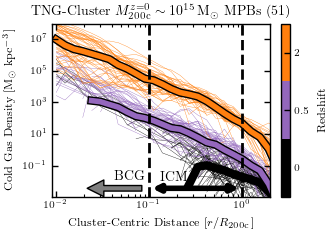

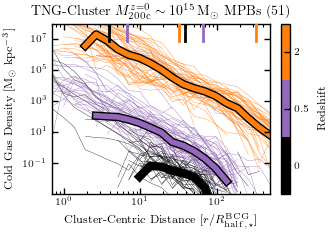

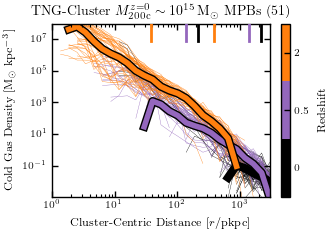

In [32]:
for norm in norms:
    fig, ax = plot_stacked_dict(grp_dict_keys, norm=norm)
    if savefig:
        fname = '%s/TNG-Cluster_M200cz01e15_ColdGasMassRadProfEvolution_%s.pdf'%(sim, norm)
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [33]:
grp_dict_keys[0]

'099_02830001'

In [34]:
# let's make some images of the cold gas
sim = 'TNG-Cluster'
basePath = ru.ret_basePath(sim)
header = ru.loadHeader(basePath, 99)
h = header['HubbleParam']
gas_ptn = il.util.partTypeNum('gas')
gas_hsml_fact = 1.5
Tcoollim = 10.**(4.5)
axes = [0,1]
nPixels = 2048

group = grp_dict[grp_dict_keys[3]]
redshift = 0.0

time_index = np.argmin(np.abs(group['Redshift'] - redshift))

haloID = group['HostSubhaloGrNr'][time_index]
snapNum = group['SnapNum'][time_index]
a = group['Time'][time_index]
boxsize = header['BoxSize'] * a / h

halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
HaloPos = halo['GroupPos'] * a / h
R200c = halo['Group_R_Crit200'] * a / h




In [35]:

gas_cells = il.snapshot.loadOriginalZoom(basePath, snapNum, haloID, gas_ptn)
gas_cells = ru.calc_temp_dict(gas_cells)

Masses = gas_cells['Masses'] * 1.0e10 / h
_Coordinates = gas_cells['Coordinates'] * a / h
Coordinates = ru.shift(_Coordinates, HaloPos, boxsize)
Densities = gas_cells['Density'] * 1.0e10 / h / (a / h)**3
Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact
Temperatures = gas_cells['Temperature']

temp_mask = Temperatures <= Tcoollim
mass_mask = Masses < 1.0e8
depth = 5. * R200c
depth_mask = np.abs(Coordinates[:,2]) <= depth

mask = temp_mask & mass_mask & depth_mask

pos = Coordinates[:,axes][mask]
hsml = Sizes[mask]
mass = Masses[mask]
quant = None
boxSizeImg = [3.*R200c, 3.*R200c] # kpc
boxSizeSim = [boxsize, boxsize, boxsize]
boxCen = [0., 0.]   
ndims = 3



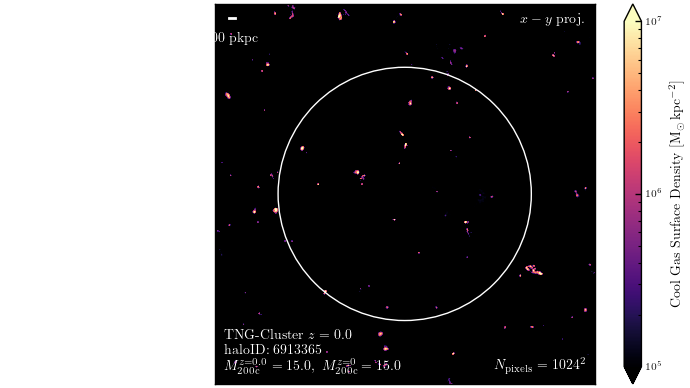

In [36]:
nPixels_ar = [1024]

for nPixels in nPixels_ar:

    coolgasmap = sphMap.sphMap(pos, hsml, mass, quant, axes, boxSizeImg, boxSizeSim, boxCen, [nPixels, nPixels], ndims, colDens=True)

    mask = coolgasmap > 0
    #vmin = np.percentile(coolgasmap[mask], 5)
    #vmax = np.percentile(coolgasmap[mask], 95)
    vmin = 1.0e5
    vmax = 1.0e7

    fig, ax = plt.subplots()
    cmap = mpl.cm.magma.copy()
    cmap.set_under('black')
    cmap.set_bad('black')
    extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[1]/2., boxSizeImg[1]/2.]
    img = ax.imshow(coolgasmap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap, origin='lower', extent=extent)
    cbar = fig.colorbar(img, ax=ax, extend='both', label=r'Cool Gas Surface Density $[{\rm M_\odot\, kpc^{-2}}]$')
    ax.set_xticks([])
    ax.set_yticks([])

    circle_r200c = plt.Circle((0., 0.), R200c, color='white', fill=False)
    ax.add_patch(circle_r200c)

    x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.075)# kpc
    y0 = boxSizeImg[1]/2. -(boxSizeImg[1]/2. * 0.075)# kpc
    length = 100  #kpc
    ax.plot([x0, x0+length], [y0, y0], color='white', marker='None', ls='-')
    ax.text(x0+length/2., y0-(boxSizeImg[1]/2. * 0.075), '%d pkpc'%int(length), ha='center', va='top', color='white')
    ax.text(0.975, 0.975, r'$x-y$ proj.', ha='right', va='top', transform=ax.transAxes, color='white')

    text = (r'TNG-Cluster $z=%.1f$'%redshift + '\n'
            'haloID: %d \n'%haloID + 
            r'$M_{\rm 200c}^{z=%.1f}=%.1f,\ M_{\rm 200c}^{z=0}=%.1f$'%(redshift,
                                                                    np.log10(group['HostGroup_M_Crit200'][time_index]),
                                                                    np.log10(group['HostGroup_M_Crit200'][0])))
    ax.text(0.025, 0.025, text, ha='left', va='bottom', ma='left', transform=ax.transAxes, color='white')

    ax.text(0.975, 0.025, r'$N_{\rm pixels} = %d^2$'%nPixels, ha='right', va='bottom', transform=ax.transAxes, color='white')

    if savefig:
        _outdirec = outdirec + '%s/'%sim + 'CoolGasMaps/'
        if not os.path.isdir(_outdirec):
            os.makedirs(_outdirec)
        _outfname = '%s_snapNum%03d_haloID%s_CoolGasColDens_OriginalZoom_nPixels%d.pdf'%(sim, snapNum, haloID, nPixels)
        fig.savefig(_outdirec + _outfname, bbox_inches='tight')

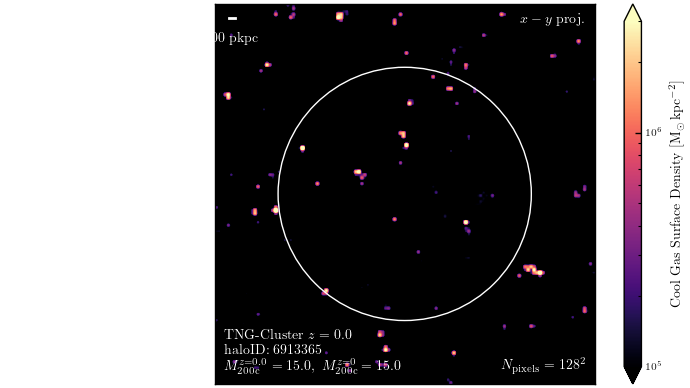

In [37]:
nPixels_ar = [128]

for nPixels in nPixels_ar:

    area = (boxSizeImg[0] / nPixels)**2
    extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[1]/2., boxSizeImg[1]/2.]
    range = [[-boxSizeImg[0]/2., boxSizeImg[0]/2.], [-boxSizeImg[0]/2., boxSizeImg[0]/2.]]
    _pos = ru.shift(pos, boxCen, boxsize)
    coolgasmap = np.histogram2d(_pos[:,0], _pos[:,1], bins=nPixels, weights=mass / area, range=range)[0].T
    
    vmin = 1.0e5
    vmax = 3.0e6

    fig, ax = plt.subplots()
    cmap = mpl.cm.magma.copy()
    cmap.set_under('black')
    cmap.set_bad('black')
    img = ax.imshow(coolgasmap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap, origin='lower', extent=extent)
    cbar = fig.colorbar(img, ax=ax, extend='both', label=r'Cool Gas Surface Density $[{\rm M_\odot\, kpc^{-2}}]$')
    ax.set_xticks([])
    ax.set_yticks([])

    circle_r200c = plt.Circle((0., 0.), R200c, color='white', fill=False)
    ax.add_patch(circle_r200c)

    x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.075)# kpc
    y0 = boxSizeImg[1]/2. -(boxSizeImg[1]/2. * 0.075)# kpc
    length = 100  #kpc
    ax.plot([x0, x0+length], [y0, y0], color='white', marker='None', ls='-')
    ax.text(x0+length/2., y0-(boxSizeImg[1]/2. * 0.075), '%d pkpc'%int(length), ha='center', va='top', color='white')
    ax.text(0.975, 0.975, r'$x-y$ proj.', ha='right', va='top', transform=ax.transAxes, color='white')

    text = (r'TNG-Cluster $z=%.1f$'%redshift + '\n'
            'haloID: %d \n'%haloID + 
            r'$M_{\rm 200c}^{z=%.1f}=%.1f,\ M_{\rm 200c}^{z=0}=%.1f$'%(redshift,
                                                                    np.log10(group['HostGroup_M_Crit200'][time_index]),
                                                                    np.log10(group['HostGroup_M_Crit200'][0])))
    ax.text(0.025, 0.025, text, ha='left', va='bottom', ma='left', transform=ax.transAxes, color='white')

    ax.text(0.975, 0.025, r'$N_{\rm pixels} = %d^2$'%nPixels, ha='right', va='bottom', transform=ax.transAxes, color='white')


In [38]:
# let's make some quick comparisons to Lora et al. (2024)
sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)
snapNum = 91
subfindID = 119447
gas_ptn = il.util.partTypeNum('gas')
dm_ptn = il.util.partTypeNum('dm')
star_ptn = il.util.partTypeNum('star')
subhalo = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subfindID)
haloID = subhalo['SubhaloGrNr']
halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)

header = ru.loadHeader(basePath, snapNum)
h = header['HubbleParam']
a = header['Time']
BoxSize = header['BoxSize'] * a / h
dm_mass = header['MassTable'][dm_ptn] * 1.0e10 / h

subhalo_gas = il.snapshot.loadSubhalo(basePath, snapNum, subfindID, gas_ptn)
subhalo_dm = il.snapshot.loadSubhalo(basePath, snapNum, subfindID, dm_ptn)
subhalo_star = il.snapshot.loadSubhalo(basePath, snapNum, subfindID, star_ptn)

fof_gas = il.snapshot.loadHalo(basePath, snapNum, haloID, gas_ptn)
fof_dm = il.snapshot.loadHalo(basePath, snapNum, haloID, dm_ptn)
fof_star = il.snapshot.loadHalo(basePath, snapNum, haloID, star_ptn)

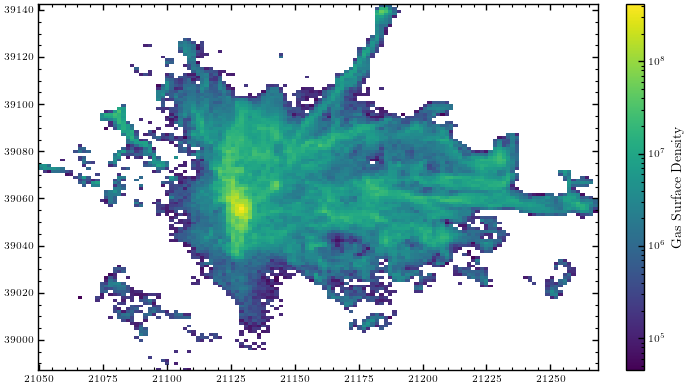

In [39]:
gas_cells = subhalo_gas

pos = subhalo['SubhaloPos'] * a / h

Masses = gas_cells['Masses'] * 1.0e10 / h
_Coordinates = gas_cells['Coordinates'] * a / h
Coordinates = ru.shift(_Coordinates, pos, BoxSize)
Densities = gas_cells['Density'] * 1.0e10 / h / (a / h)**3
Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact

fig, ax = plt.subplots()
hist2d = ax.hist2d(_Coordinates[:,0], _Coordinates[:,1], weights=Masses, bins=128, norm=mpl.colors.LogNorm())
fig.colorbar(hist2d[3], label=r'Gas Surface Density', ax=ax)



dwarf_pos_xy = [21184., 39140.]

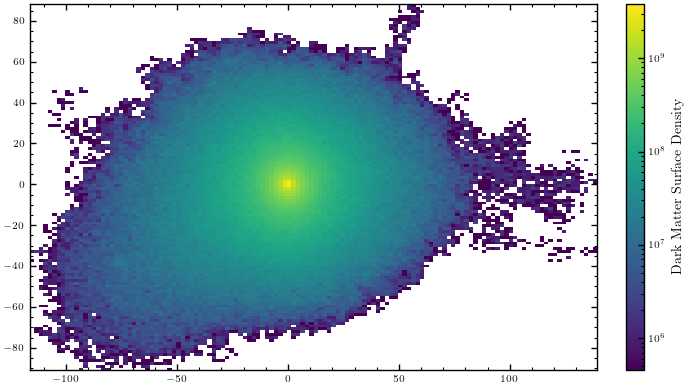

In [40]:
gas_cells = subhalo_dm

pos = subhalo['SubhaloPos'] * a / h

Masses = np.ones(gas_cells['count']) * dm_mass 
_Coordinates = gas_cells['Coordinates'] * a / h
Coordinates = ru.shift(_Coordinates, pos, BoxSize)
#Densities = gas_cells['Density'] * 1.0e10 / h / (a / h)**3
#Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact

fig, ax = plt.subplots()
hist2d = ax.hist2d(Coordinates[:,0], Coordinates[:,1], weights=Masses, bins=128, norm=mpl.colors.LogNorm())
fig.colorbar(hist2d[3], label=r'Dark Matter Surface Density', ax=ax)

In [41]:
gas_cells = fof_gas

pos = halo['GroupPos'] * a / h

Masses = gas_cells['Masses'] * 1.0e10 / h
_Coordinates = gas_cells['Coordinates'] * a / h
Coordinates = ru.shift(_Coordinates, pos, BoxSize)
Densities = gas_cells['Density'] * 1.0e10 / h / (a / h)**3
Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact

fig, ax = plt.subplots()
hist2d = ax.hist2d(_Coordinates[:,0], _Coordinates[:,1], weights=Masses, bins=128, norm=mpl.colors.LogNorm())
fig.colorbar(hist2d[3], label=r'Gas Surface Density', ax=ax)


In [42]:
halo['GroupPos']

array([15627.547, 29256.63 , 25948.59 ], dtype=float32)